In [95]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os

from scipy.signal import medfilt


basepath = r"C:\Users\Federico\Documents\GitHub\APA_setup"
os.chdir(basepath)

sys.path.append("./")
sys.path.append(basepath)
sys.path.append(os.path.join(basepath, "analysis"))


from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths.signals import rolling_mean

from analysis.process_data import DataProcessing
from analysis.fixtures import colors, sensors
from myterial import indigo, blue_grey_dark, salmon, cyan_dark

all_data = DataProcessing.reload()
from myterial import *
colors["nose"] = red_dark
colors["eye"] = orange_dark
colors["bottom ear"] = orange_darker
colors["front left heel"] = "blue"
colors["front left toe"] = blue_dark
colors["front left thumb"] = blue_darker
colors["hind left heel"] = teal
colors["hind left toe"] = teal_dark
colors["hind left thumb"] = teal_darker

CONDITION = "WT"
STRAIN = "C57"

if STRAIN is not None:
    data = all_data.data.loc[(all_data.data.condition == CONDITION)&(all_data.data.strain == STRAIN)].reset_index()
else:
    data = all_data.data.loc[(all_data.data.condition == CONDITION)].reset_index()
    STRAIN = "any"
print(len(data))


[07/14/22 22:26:26] INFO     Starting data pre-processing with trials     ]8;id=496380;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=809161;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#121\121]8;;\
                             file: F:\Egzona\Forceplate\Analysis backup\1                    
                             00422_ALLtrials_CTRL-DTR_conditions.csv.                        

                    INFO     Caliration file: F:\Egzona\Forceplate\forcep ]8;id=714524;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=440929;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#124\124]8;;\
                             latesensors_calibration4.csv.                                   

                    INFO     Found 36 subfolders                           ]8;id=450095;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=846160;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#55\55]8;;\

                    DEBUG    Setting previously stored params: {'DEBUG':   ]8;id=540719;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=455078;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#91\91]8;;\
                             True, 'CONDITIONS': ['WT', 'CTRL', 'DTR',                       
                             'CNO'], 'STRAINS': ['C57', 'VGLUT'],                            
                             'STANDING_STILL': False, 'calibrate': True,                     
                             'weight_percentage': True, 'correct_for_paw':                   
                             True, 'frames_file':                                            
                             'F:\\Egzona\\Forceplate\\Analysis backup\\100                   
                             422_ALLtrials_CTRL-DTR_conditions.csv',                         
                             'calibration_file': 'F:\\Egzona\\Forceplate\\                   
                             forceplatesensors_calibration4.csv',                            
                             'main_fld': 'F:\\Egzona\\Forceplate\\CURRENT                    
                             ANALYSIS TRIALS', 'fps': 600,                                   
                             'smoothing_window': 0.01,                                       
                             'on_sensor_weight_th': 2,                                       
                             'on_all_sensors_weight_th': 66,                                 
                             'n_secs_before': 0.2, 'n_secs_after': 0.2,                      
                             'min_baseline_duration': 0,                                     
                             'trial_start_detection_window': 0.15,                           
                             'plot_individual_trials': False}                                

                    INFO     Starting data pre-processing with trials     ]8;id=287306;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=914552;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#121\121]8;;\
                             file: F:\Egzona\Forceplate\Analysis backup\1                    
                             00422_ALLtrials_CTRL-DTR_conditions.csv.                        

                    INFO     Caliration file: F:\Egzona\Forceplate\forcep ]8;id=919399;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=348742;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#124\124]8;;\
                             latesensors_calibration4.csv.                                   

                    INFO     Loading previously saved data from:           ]8;id=275545;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=953320;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#96\96]8;;\
                             F:\Egzona\Forceplate\CURRENT ANALYSIS                           
                             TRIALS\data.h5                                                  

                    INFO     Loaded 91 trials -----                       ]8;id=492623;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=787225;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#103\103]8;;\
                                                                                             
                                                                                             

61


In [70]:
dlc_data_folder = Path(r"F:\Egzona\Forceplate\Thesis_DLC\Thesis Deeplabcut-Egzona-2022-06-09\Thesis_DLC-Egzona Morina-2022-06-17\videos")
vids = [f.name for f in dlc_data_folder.glob("*.mp4") if "DLC" not in f.stem]
vids_frame_num = [int(f.stem.split("_")[-1].split(".")[0]) for f in dlc_data_folder.glob("*.mp4") if "DLC" not in f.stem]

isin = []
hdf_files = []
dlc_vidname = []
for i, trial in data.iterrows():
    if not Path(trial.video).exists():
        print(f"Could not find video for trial: {trial.video}")
        continue
    
    name = trial['name'].replace("_cam0", "")
    fnum = trial.movement_onset_frame
    if fnum not in vids_frame_num:
        fnum += 1
        
    vidname = f"{name}_{fnum}.mp4"
    if vidname in vids:
        isin.append(i)
        hdf_files.append(
            dlc_data_folder / (vidname.replace(".mp4", "") + "DLC_resnet50_Thesis_DLCJun17shuffle1_500000.h5")
        )
        dlc_vidname.append(vidname)
    else:
        print(f"Could not find video for trial {name} at frame {trial.movement_onset_frame}: {trial.video}")
        continue

print(f"{len(isin)}/{len(data)}")
data = data.iloc[isin]
data["dlc_hdf"] = hdf_files
data["dlc_vidname"] = dlc_vidname

Could not find video for trial 28012020_M_2R at frame 148747: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\28012020\28012020_M_2R_cam0.avi
Could not find video for trial 29012020_M_2R_2 at frame 41471: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\29012020\29012020_M_2R_2_cam0.avi
Could not find video for trial 29012020_M_2R_3 at frame 13968: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\29012020\29012020_M_2R_3_cam0.avi
Could not find video for trial 29012020_M_2R_3 at frame 145952: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\29012020\29012020_M_2R_3_cam0.avi
Could not find video for trial 29012020_M_2R at frame 53036: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\29012020\29012020_M_2R_cam0.avi
Could not find video for trial 29012020_M_2R at frame 143713: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\29012020\29012020_M_2R_cam0.avi
Could not find video for trial 060720_F_1L at frame 109407: F:\Egzona\Forceplate\CURRENT ANALYSIS TRIALS\060720\060720_F_1L_cam0.avi
Could not find video for

In [71]:
# keep only trial where mouse steps with the left paw first
data = data.loc[data.paw == "L"]
print(len(data))

17


We've selected the trials for which we could match the DLC data with the analyzied force plate data. Now we load the DLC data.


**NOTE:** when loading the DLC trials we cut 180 frames at start and end to align to sensors data which only has .2s before and after movement onset

In [72]:

def get_scorer_bodyparts(tracking):
    """
        Given the tracking data hierarchical df from DLC, return
        the scorer and bodyparts names
    """
    first_frame = tracking.iloc[0]
    bodyparts = first_frame.index.levels[1]
    scorer = first_frame.index.levels[0]
    return scorer, bodyparts


def load_dlc_tracking(tracking_file: str):
    """
        load and unstack tracking data from a DLC file
    """
    tracking = pd.read_hdf(tracking_file)

    bodyparts = tracking.iloc[0].index.levels[1]
    scorer = tracking.iloc[0].index.levels[0]

    tracking = tracking.unstack()

    trackings = {}
    for bp in bodyparts:
        x = 240 - tracking.loc[scorer, bp, "x"].values
        y = 140 - tracking.loc[scorer, bp, "y"].values

        x = medfilt(x, kernel_size=5)
        y = medfilt(y, kernel_size=5)
        
        like = tracking.loc[scorer, bp, "likelihood"].values
        x[like < .6] = np.nan
        y[like < .6] = np.nan


        trackings[bp] = dict(
            x=x[180:-180], y=y[180:-180], like=like[180:-180]
        )
    return trackings

In [73]:
dlc_data = {
    r.dlc_vidname: load_dlc_tracking(r.dlc_hdf) for _, r in data.iterrows()
}
len(dlc_data)

17

## Plot a single trial

[Text(0.5, 0, 'time (frame)'), Text(0, 0.5, 'weight (%)')]

<Figure size 1152x648 with 2 Axes>

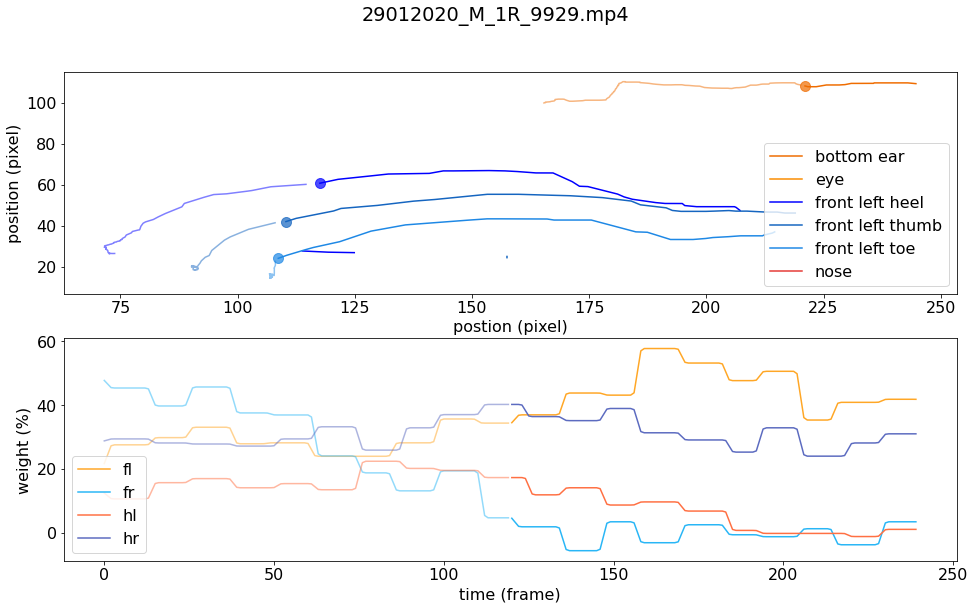

In [74]:
trial = list(dlc_data.keys())[2]
dataentry = data.loc[data.dlc_vidname == trial].iloc[0]

bps = [b for b in dlc_data[trial].keys() if "hind" not in b and "tail" not in b and "right" not in b]

f, axes = plt.subplots(2, 1, figsize=(16, 9))

for bp in bps:
    axes[0].plot(dlc_data[trial][bp]["x"][:120], dlc_data[trial][bp]["y"][:120], alpha=.5, color=colors[bp])
    axes[0].scatter(dlc_data[trial][bp]["x"][120], dlc_data[trial][bp]["y"][120], alpha=.7, s=100, color=colors[bp])
    axes[0].plot(dlc_data[trial][bp]["x"][120:], dlc_data[trial][bp]["y"][120:], label=bp, color=colors[bp])

for paw in sensors:
    axes[1].plot(dataentry[paw][:120], alpha=.5, color=colors[paw])
    axes[1].plot(np.arange(120, 240), dataentry[paw][120:], label=paw, color=colors[paw])

f.suptitle(trial)
axes[0].legend()
axes[1].legend()

axes[0].set(xlabel="postion (pixel)", ylabel="position (pixel)")
axes[1].set(xlabel="time (frame)", ylabel="weight (%)")


## Movement analysis
For each trial and each body part compute the distance from the position at the first frame over time


In [75]:
bps = (
    "front left heel", "front left toe", "front left thumb",
    "eye", "bottom ear"
)

def dist(trial, bp):
    # trace = np.vstack(
    #     [trial[bp]["x"], trial[bp]["y"]]
    # ).T
    trace = trial[bp]["x"]

    # find first frame in which each entry in trace is not nan
    # first_frame = np.argmin(np.sum(np.isnan(trace), axis=1))

    # return np.sqrt(np.sum((trace - trace[first_frame])**2, axis=1))[:, 0]
    return trace - trace[0]
    

def paw_angle(trial):
    heel = trial["front left heel"]
    toe = trial["front left toe"]

    deltax = heel["x"] - toe["x"]
    deltay = heel["y"] - toe["y"]
    return np.degrees(np.arctan2(deltax, deltay)) + 90


distances = {
    k:{
        bp:dist(v, bp) for bp in bps
    } for k,v in dlc_data.items()
}

paw_angles = {k: paw_angle(v) for k,v in dlc_data.items()}


Plot an example trial

<Figure size 1152x1008 with 5 Axes>

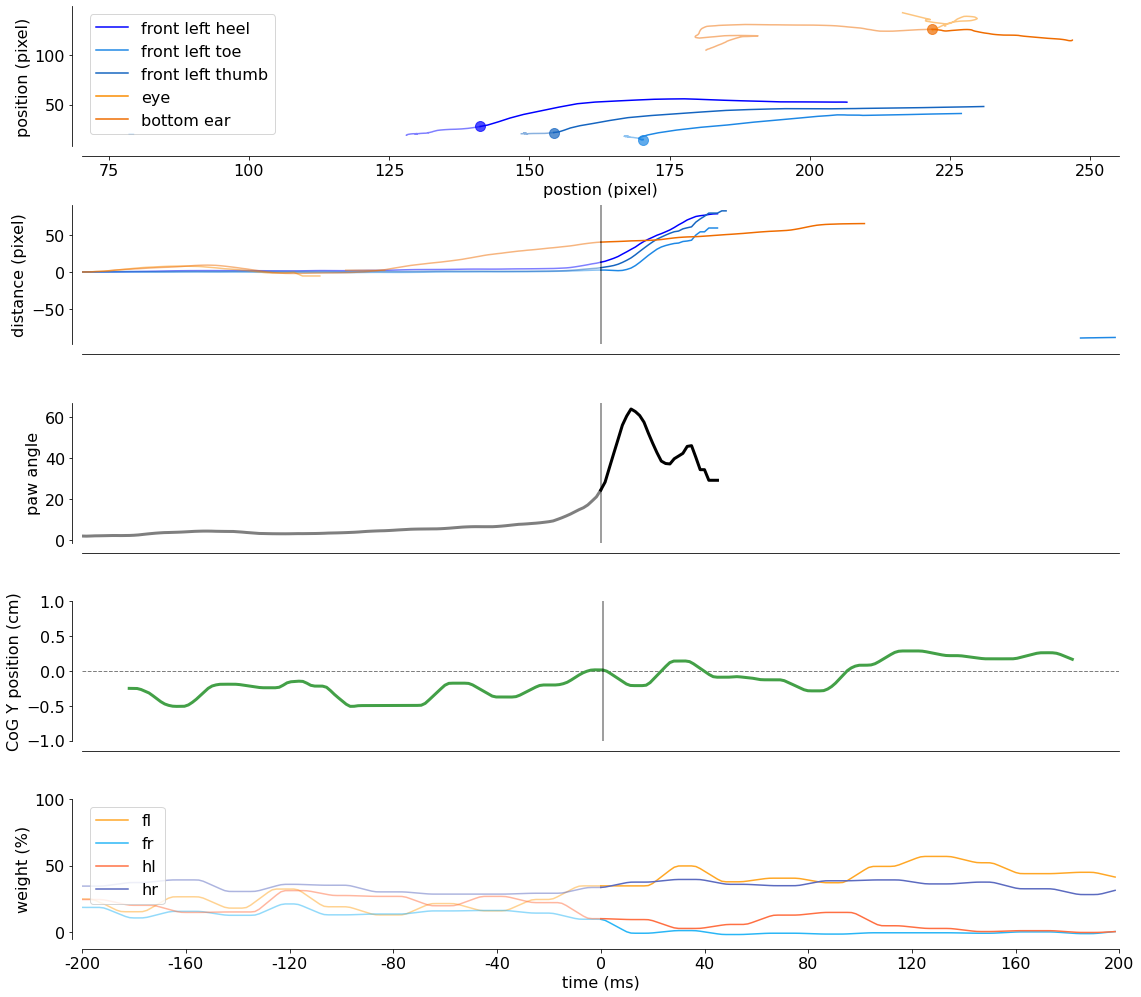

In [76]:
# set plt font size
plt.rcParams.update({'font.size': 16})

trial = list(dlc_data.keys())[10]
dataentry = data.loc[data.dlc_vidname == trial].iloc[0]
trial_distances = distances[trial]


f, axes = plt.subplots(5, 1, figsize=(16, 14))


t0 = np.arange(0, 121)
t1 = np.arange(120, 240)

# plot paw position and distance from start
for bp in bps:
    x = rolling_mean(dlc_data[trial][bp]["x"], 6)
    y = rolling_mean(dlc_data[trial][bp]["y"], 6)
    d = rolling_mean(trial_distances[bp], 6)

    axes[0].plot(x[:121], y[:121], alpha=.5, color=colors[bp])
    axes[0].scatter(x[120], y[120], alpha=.7, s=100, color=colors[bp])
    axes[0].plot(x[120:], y[120:], label=bp, color=colors[bp])

    axes[1].plot(t0, d[:121], alpha=.5, color=colors[bp])
    axes[1].plot(t1, d[120:], label=bp, color=colors[bp])

# plot paw angle
a = rolling_mean(paw_angles[trial], 6)
axes[2].plot(t0, a[:121], color="k", lw=3, alpha=.5)
axes[2].plot(t1, a[120:], color="k", lw=3, label="paw angle")

# plot pressure sensors trces
for paw in sensors:
    p = rolling_mean(dataentry[paw], 6)
    axes[4].plot(t0, p[:121], alpha=.5, color=colors[paw])
    axes[4].plot(t1, p[120:], label=paw, color=colors[paw])

# plot CoG
c = rolling_mean(dataentry["CoG"][:, 1], 6)
axes[3].plot(c, lw=3, color=green_dark)
axes[3].axhline(0, lw=1, ls="--", color="k", alpha=.5, zorder=-1)

# f.suptitle(trial)
axes[0].legend()
axes[4].legend()

for ax in (1, 2, 3):
    axes[ax].axvline(120, color="k", alpha=.5)

axes[0].set(xlabel="postion (pixel)", ylabel="position (pixel)")
axes[1].set( ylabel="distance (pixel)", xticks=[], xlim=[0, 240])
axes[2].set( ylabel="paw angle", xticks=[], xlim=[0, 240])
axes[3].set(xticks=[], ylabel="CoG Y position (cm)", ylim=[-1, 1])
axes[4].set(xlabel="time (ms)",
    ylabel="weight (%)",
    xticks=np.linspace(0, 240, 11),
    xticklabels=[round(x-200) for x in np.linspace(0, 240, 11) * 1000/600],
    xlim=[0, 240], ylim=[-5, 100])

f.tight_layout()
clean_axes(f)

f.savefig("F:\\Egzona\\Thesis_Paper_Figures\\FC\\dlc_example_trial.svg", dpi=300)

## Plot averages

C:\Users\Federico\AppData\Local\Temp\ipykernel_22360\413249268.py:6: RuntimeWarning: Mean of empty slice
  d = np.nanmean(D, axis=0)
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Federico\AppData\Local\Temp\ipykernel_22360\413249268.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  avg_angle = np.nanmean(np.vstack(paw_angles.values()), axis=0)
C:\Users\Federico\AppData\Local\Temp\ipykernel_22360\413249268.py:18: RuntimeWarning: Mean of empty slice
  avg_angle = np.nanmean(np.vstack(paw_angles.values()), axis=0)
C:\Users\Federico\AppData\Local\Temp\ipykernel_22360\413249268.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list 

<Figure size 1152x1152 with 3 Axes>

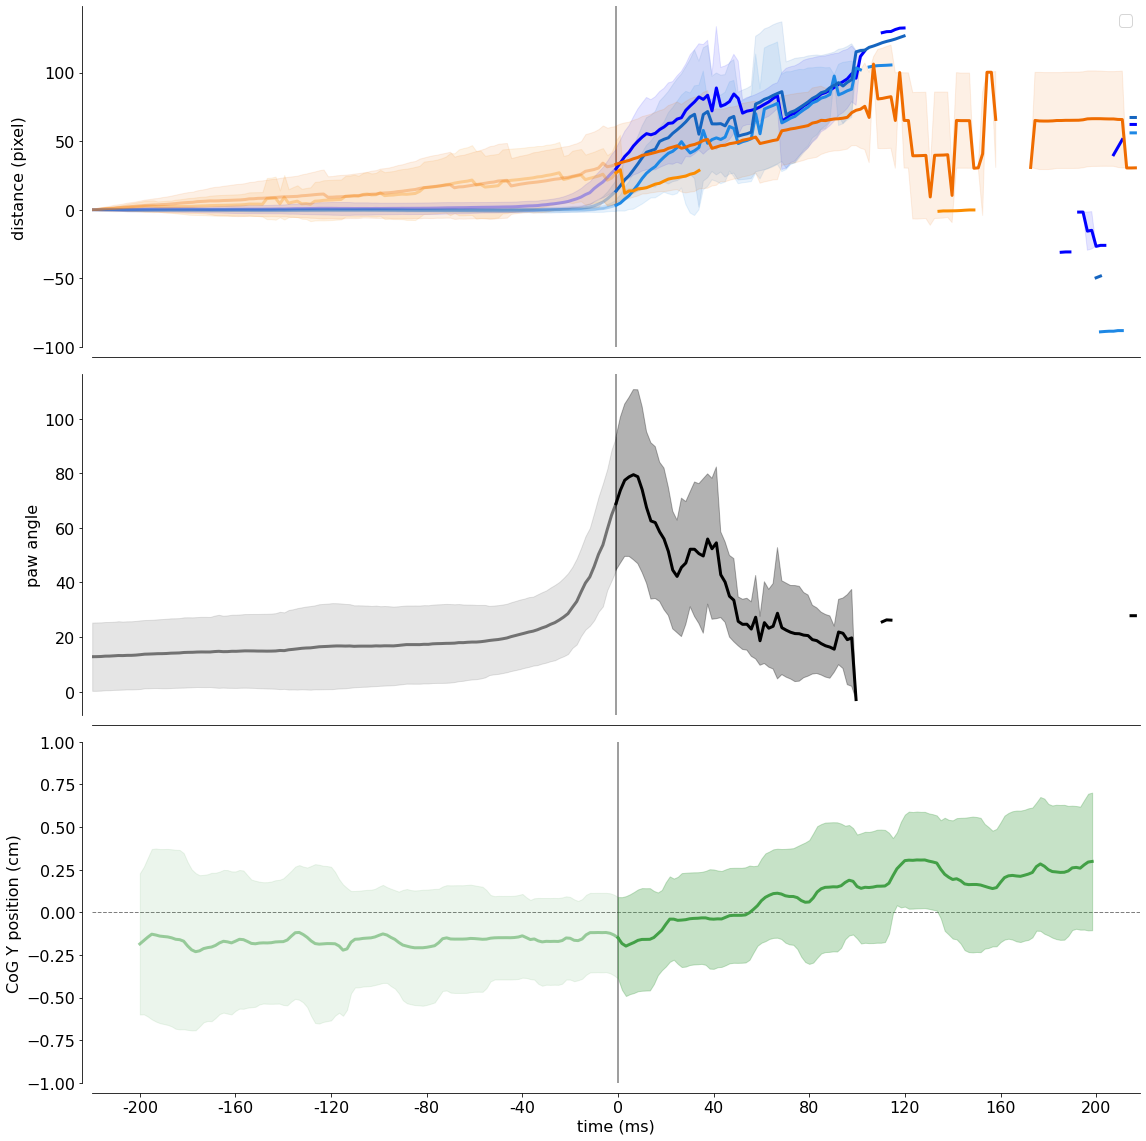

In [77]:
f, axes = plt.subplots(3, 1, figsize=(16, 16))

# plot average distance traces
for bp in bps:
    D = np.vstack([distances[k][bp] for k in distances.keys()])
    d = np.nanmean(D, axis=0)
    d_std = np.nanstd(D, axis=0)

    plot_mean_and_error(
        d[:121], d_std[:121], axes[0], err_alpha=.1, color=colors[bp], alpha=.3
    )
    plot_mean_and_error(
        d[120:], d_std[120:], axes[0], x=t1, err_alpha=.1, color=colors[bp]
    )


# plot angle average trace
avg_angle = np.nanmean(np.vstack(paw_angles.values()), axis=0)
avg_angle_std = np.nanstd(np.vstack(paw_angles.values()), axis=0)

plot_mean_and_error(
    avg_angle[:121], avg_angle_std[:121], axes[1], err_alpha=.1, alpha=.5, x=t0, color="k"
)
plot_mean_and_error(
    avg_angle[120:], avg_angle_std[120:], axes[1], err_alpha=.3, alpha=1, x=t1, color="k"
)

# plot average CoG Y trajectory
y = np.nanmean(np.dstack(data.CoG.values)[:, 1, :], axis=1)
y_std = np.nanstd(np.dstack(data.CoG.values)[:, 1, :], axis=1)
plot_mean_and_error(
    y[:121], y_std[:121], axes[2], err_alpha=.1, alpha=.5, x=t0, color=green_dark
)
plot_mean_and_error(
    y[120:], y_std[120:], axes[2], err_alpha=.3, alpha=1, x=t1, color=green_dark
)
axes[2].axhline(0, lw=1, ls="--", color="k", alpha=.5, zorder=-1)


axes[0].legend()

for ax in (0, 1, 2):
    axes[ax].axvline(120, color="k", alpha=.5)

axes[0].set( ylabel="distance (pixel)", xticks=[], xlim=[0, 240])
axes[1].set( ylabel="paw angle", xticks=[], xlim=[0, 240])
axes[2].set(ylabel="CoG Y position (cm)", ylim=[-1, 1],
    xticks=np.linspace(0, 240, 11),
    xticklabels=[round(x-200) for x in np.linspace(0, 240, 11) * 1000/600], xlabel="time (ms)")
    

f.tight_layout()
clean_axes(f)

# save figure
f.savefig("F:\\Egzona\\Thesis_Paper_Figures\\FC\\dlc_analysis_avg.svg", dpi=300)

## Angle analysis

Look at the paw angle traces and try to devine the inflection point.

Mean paw inflection time: 22.353 ms (median: 20.000 ms) and std: 15.169 ms


<Figure size 1152x648 with 1 Axes>

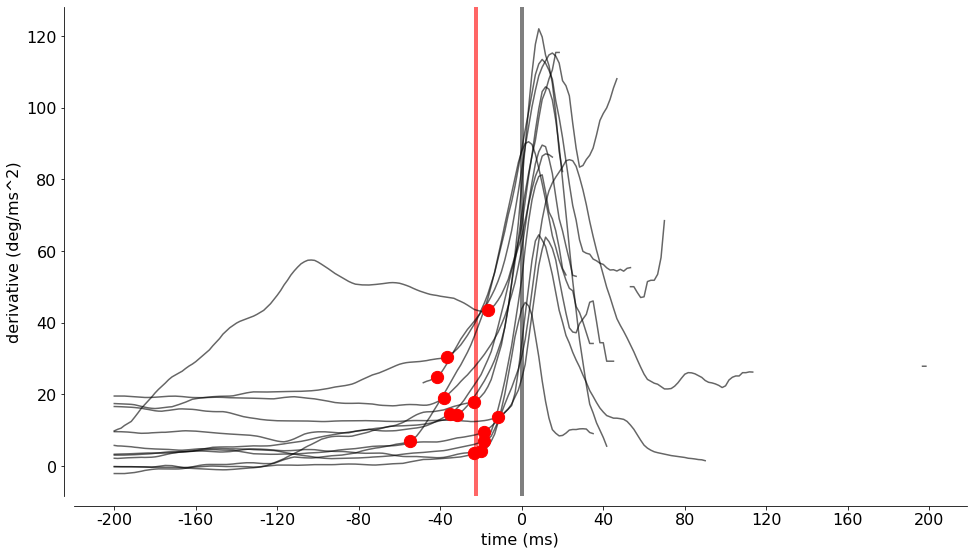

In [83]:
f, ax = plt.subplots(figsize=(16, 9))

paw_inflection_times = []
for k, v in paw_angles.items():
    v = rolling_mean(v, 6)
    dv = np.diff(v)

    # find the last time before frame 120 when the derivative of v is > 2
    try:
        t = np.where(dv[:120] < .75)[0][-1]
        paw_inflection_times.append(t)
    except:
        t = np.argmax(dv[:120])
        # continue
    if t > 115:
        continue

    # ax.plot(np.diff(v), label=k, color="k", alpha=.6)
    ax.plot(v, label=k, color="k", alpha=.6)
    ax.scatter(t, v[t], color="red", zorder=100, s=150)


def frame2ms(frame):
    return frame / 600 * 1000

mean_t = frame2ms(120 - np.mean(paw_inflection_times))
median_t = frame2ms(120 - np.median(paw_inflection_times))
std_t = frame2ms(np.std(paw_inflection_times))
ax.axvline(np.mean(paw_inflection_times), color="r", lw=4, zorder=-1, alpha=.6)
ax.axvline(120, color="k", lw=4, zorder=-1, alpha=.5)

print(f"Mean paw inflection time: {mean_t:.3f} ms (median: {median_t:.3f} ms) and std: {std_t:.3f} ms")

clean_axes(f)
_ = ax.set(
    ylabel="derivative (deg/ms^2)",
    xticks=np.linspace(0, 240, 11),
    xticklabels=[round(x-200) for x in np.linspace(0, 240, 11) * 1000/600], xlabel="time (ms)"
)

f.savefig("F:\\Egzona\\Thesis_Paper_Figures\\FC\\dlc_analysis_angle_change_timing.svg", dpi=300)

## CoM analysis

Look at the Y component of the CoM.

In [157]:
wt = all_data.data.loc[all_data.data.condition == "WT"]
COGs = np.dstack([v for v in wt["CoG"].values])
cog = np.mean(COGs, 2)
cog_std = np.std(COGs, 2)

In [158]:
from scipy import optimize


def segments_fit(X, Y, count):
    """
        from https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
    """
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)


[(0.0, 240.0), (-1.0, 1.0)]

<Figure size 1152x648 with 1 Axes>

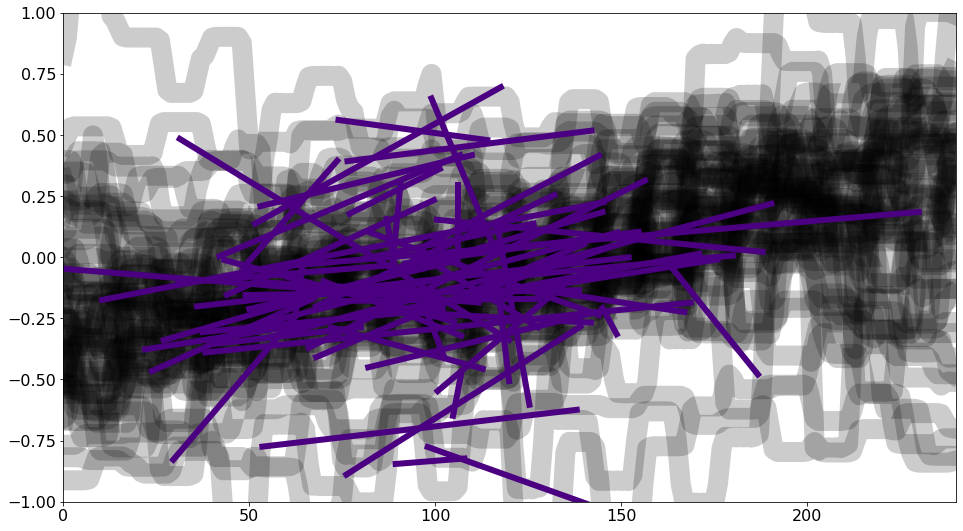

In [159]:
f, ax = plt.subplots(figsize=(16, 9))



flat_starts = []
flat_stops = []
for i in range(COGs.shape[-1]):
    y = rolling_mean(COGs[:, 1, i], 1)

    px, py = segments_fit(np.arange(len(y)), y, 4)

    ax.plot(
        y,
        color='k', alpha=.2, lw=20, zorder=-1
    )

    # ax.plot([px[0], px[1]], [py[0], py[1]], color="red", alpha=1, lw=6, label="fit")
    # # ax.plot(px[1:3], py[1:3], color=indigo, alpha=1, lw=6, label="fit")
    ax.plot([px[1], px[2]], [py[1], py[2]], color="indigo", alpha=1, lw=6, label="fit")
    # ax.plot([px[2], px[3]], [py[2], py[3]], color="green", alpha=1, lw=6, label="fit")

    if 0 < px[1] < 240:
        flat_starts.append(px[1])

    if 0 < px[2] < 240:
        flat_stops.append(px[2])
    
    # ax.scatter(px, py, s=250, lw=4, ec=indigo, fc="white", zorder=100)


ax.set(xlim=[0, 240], ylim=[-1, 1])
    # if i == 5:
    #     break
    

In [160]:
print(f"""

    Flat bit starts: {frame2ms(-1 * (120 - np.mean(flat_starts))):.3f} ms (std: {frame2ms(-1 * (120 - np.std(flat_starts))):.3f} ms)
    Flat bit stops: {frame2ms(-1 * (120 - np.mean(flat_stops))):.3f} ms (std: {frame2ms(-1 * (120 - np.std(flat_stops))):.3f} ms)

""")



    Flat bit starts: -75.149 ms (std: -140.777 ms)
    Flat bit stops: 11.002 ms (std: -144.889 ms)




[(0.0, 240.0), (-1.0, 1.0)]

<Figure size 1152x648 with 1 Axes>

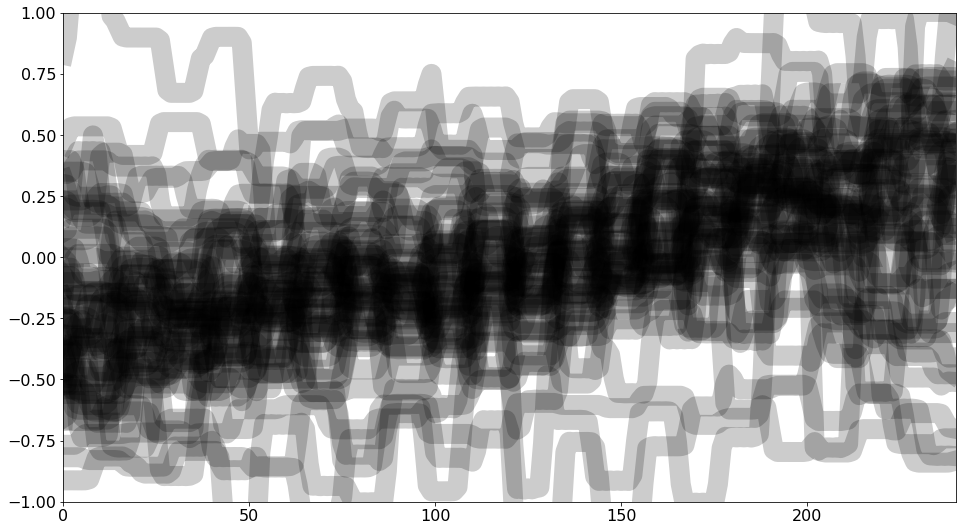

In [161]:
f, ax = plt.subplots(figsize=(16, 9))


for i in range(COGs.shape[-1]):
    y = rolling_mean(COGs[:, 1, i], 1)



    ax.plot(
        y,
        color='k', alpha=.2, lw=20, zorder=-1
    )

# ax.axvline(np.mean(flat_starts))
# ax.axvline(np.mean(flat_stops))


ax.set(xlim=[0, 240], ylim=[-1, 1])
    # if i == 5:
    #     break
    